In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split
import kagglehub as kh
from sklearn.metrics import confusion_matrix

NORMALIZE_COUNTS = True

In [37]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

if NORMALIZE_COUNTS:
    min_count = data_by_decade['label'].value_counts().min()
    data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)

X = data_by_decade.drop(columns=[ "label"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_by_decade = pd.concat([pd.DataFrame(data_by_decade["label"]), pd.DataFrame(X_scaled, columns=X.columns)], axis=1)

data_by_decade["label"].value_counts()

Path to dataset files: /home/koris/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


label
2000s      308400
1990s      124713
1980s       41814
1970s       24745
<=1960s     15673
Name: count, dtype: int64

In [38]:
avg_cols = [f'TimbreAvg{i}' for i in range(1, 13)]
cov_cols = [f'TimbreCovariance{i}' for i in range(1, 79)]
feature_cols = avg_cols + cov_cols

data_by_decade["label"] = data_by_decade["label"].astype("category")
label_lookup = dict(enumerate(data_by_decade['label'].cat.categories))
train, test = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])
test_lookup = dict(enumerate(test['label'].cat.categories))
train_lookup = dict(enumerate(train['label'].cat.categories))
train["label"] = train["label"].cat.codes
test["label"] = test["label"].cat.codes
assert test_lookup == train_lookup
assert test_lookup == label_lookup

test_label = test["label"].astype("category").cat.codes
train_label = train["label"].astype("category").cat.codes
test.drop("label", axis=1, inplace=True)
train.drop("label", axis=1, inplace=True)

og_cat_test = test.copy()
og_cat_test_label = test_label.copy()

### CatBoost Training (full)

Learning rate set to 0.146921
0:	learn: 1.5732972	total: 8.74ms	remaining: 8.73s
1:	learn: 1.5454816	total: 16.6ms	remaining: 8.29s
2:	learn: 1.5234878	total: 24.6ms	remaining: 8.16s
3:	learn: 1.5030428	total: 32.4ms	remaining: 8.06s
4:	learn: 1.4858379	total: 40.5ms	remaining: 8.07s
5:	learn: 1.4707727	total: 48.2ms	remaining: 7.98s
6:	learn: 1.4589160	total: 56.1ms	remaining: 7.95s
7:	learn: 1.4474108	total: 63.4ms	remaining: 7.87s
8:	learn: 1.4376052	total: 71.5ms	remaining: 7.87s
9:	learn: 1.4279783	total: 79ms	remaining: 7.83s
10:	learn: 1.4187152	total: 86.9ms	remaining: 7.81s
11:	learn: 1.4105194	total: 94.9ms	remaining: 7.81s
12:	learn: 1.4031103	total: 103ms	remaining: 7.84s
13:	learn: 1.3958964	total: 111ms	remaining: 7.83s
14:	learn: 1.3886231	total: 121ms	remaining: 7.93s
15:	learn: 1.3823552	total: 128ms	remaining: 7.87s
16:	learn: 1.3761012	total: 136ms	remaining: 7.85s
17:	learn: 1.3699335	total: 136ms	remaining: 7.85s
18:	learn: 1.3640708	total: 136ms	remaining: 7.85s
1

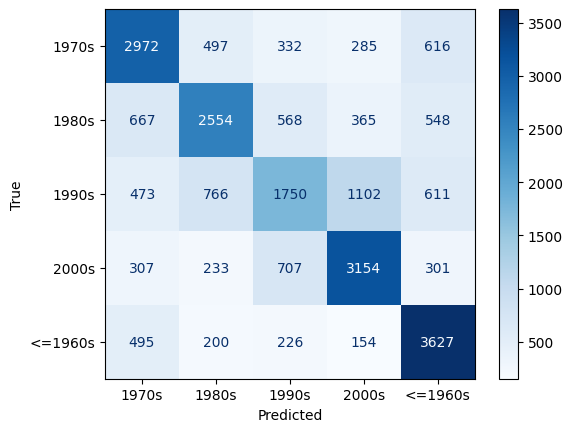

In [26]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

# CATBOOST ACCURACY
pred = cat_model.predict(test)
test_label_list = test_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)

# confusion matrix
matrix = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Training (full)

/home/koris/Documents/GitHub/MusicAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


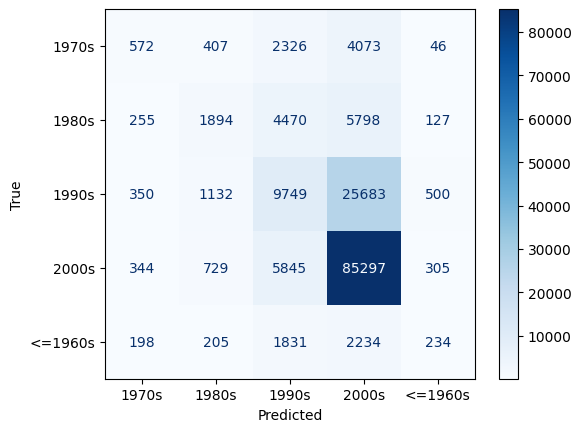

In [ ]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train, train_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test)

correct = 0
for i, label in enumerate(test_label):
    if label == multi_preds[i]:
        correct += 1

correct / len(test_label)

# confusion matrix
matrix = confusion_matrix(test_reduced_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Reduced

In [60]:
# sample down
df_sample =  train_test_split(data_by_decade, train_size=(100000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
df_sample = pd.DataFrame(df_sample[0], columns=data_by_decade.columns)

sample_train, sample_test = train_test_split(df_sample, train_size=0.7, random_state=42, stratify=df_sample["label"])

sample_test_label = sample_test["label"].astype("category").cat.codes
sample_train_label = sample_train["label"].astype("category").cat.codes
sample_test.drop("label", axis=1, inplace=True)
sample_train.drop("label", axis=1, inplace=True)


In [61]:
# ___________Find Best Alpha___________
param_grid = {'alpha': np.linspace(0.01, 1, 25)} 
grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
grid_search.fit(sample_train, sample_train_label)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Fit the model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(sample_train, sample_train_label)

# Evaluate the performance on the test set
test_score = lasso_best.score(sample_test, sample_test_label)

print(f"Best alpha from GridSearchCV: {best_alpha}")
print(f"Best cross-validation score: {best_score}")
print(f"Test R^2 score: {test_score}")


# ___________Apply Best Alpha___________

lasso = Lasso(alpha=best_alpha, random_state=1)
lasso.fit(sample_train, sample_train_label)

coef = pd.Series(lasso.coef_, index=feature_cols)
selected_features = coef[coef != 0]

# Sort by the absolute value but retain the original sign
sorted_by_abs_value = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

num_features = len(sorted_by_abs_value)
print(f"\n{num_features} Selected Features by LASSO (sorted by absolute value):")
print(sorted_by_abs_value)


Best alpha from GridSearchCV: 0.01
Best cross-validation score: 0.13885217007584588
Test R^2 score: 0.13443572739939658

44 Selected Features by LASSO (sorted by absolute value):
TimbreAvg1            0.328107
TimbreAvg2           -0.203891
TimbreAvg3           -0.085633
TimbreAvg6           -0.067660
TimbreCovariance2     0.063900
TimbreCovariance4     0.057142
TimbreAvg11          -0.045226
TimbreCovariance7     0.040455
TimbreCovariance15    0.039021
TimbreCovariance66   -0.034850
TimbreCovariance8     0.034662
TimbreCovariance11    0.033140
TimbreCovariance45   -0.031258
TimbreCovariance62    0.029325
TimbreCovariance29   -0.028178
TimbreCovariance26    0.026305
TimbreCovariance27    0.026191
TimbreCovariance46    0.021805
TimbreCovariance52    0.020611
TimbreCovariance71    0.019494
TimbreCovariance59   -0.018366
TimbreCovariance57   -0.014248
TimbreCovariance76   -0.014151
TimbreCovariance73    0.012342
TimbreCovariance51   -0.011741
TimbreAvg9           -0.011405
TimbreAvg4     

In [62]:
reduced_features = sorted_by_abs_value.index.to_list()
data_by_decade_reduced = data_by_decade.drop(columns=reduced_features)


train_reduced, test_reduced = train_test_split(data_by_decade_reduced, train_size=0.7, random_state=42, stratify=data_by_decade_reduced["label"])

test_reduced_label = test_reduced["label"].astype("category").cat.codes
train_reduced_label = train_reduced["label"].astype("category").cat.codes
test_reduced.drop("label", axis=1, inplace=True)
train_reduced.drop("label", axis=1, inplace=True)

In [ ]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train_reduced, train_reduced_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test_reduced)

correct = 0
for i, label in enumerate(test_reduced_label):
    if label == multi_preds[i]:
        correct += 1

correct / len(test_label)

# confusion matrix
matrix = confusion_matrix(test_reduced_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### CatBoost Reduced

In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

In [ ]:
cat_res.feature_names_
cat_res.feature_importances_
sorted_importances = sorted(zip(cat_res.feature_names_, cat_res.feature_importances_), key=lambda x: x[1], reverse=True)
sorted_importances

top = sorted_importances[:60]
top_names = [x[0] for x in top]

top_names
remaining_names = [x for x in cat_res.feature_names_ if x not in top_names]
remaining_names

['TimbreCovariance6',
 'TimbreCovariance19',
 'TimbreCovariance20',
 'TimbreCovariance21',
 'TimbreCovariance22',
 'TimbreCovariance23',
 'TimbreCovariance30',
 'TimbreCovariance32',
 'TimbreCovariance33',
 'TimbreCovariance36',
 'TimbreCovariance39',
 'TimbreCovariance40',
 'TimbreCovariance50',
 'TimbreCovariance54',
 'TimbreCovariance63',
 'TimbreCovariance65',
 'TimbreCovariance69',
 'TimbreCovariance72',
 'TimbreCovariance74',
 'TimbreCovariance77']

In [81]:
data_by_decade_reduced_by_importance = data_by_decade.drop(columns=remaining_names)


train_reduced_by_importance, test_reduced_by_importance = train_test_split(data_by_decade_reduced_by_importance, train_size=0.7, random_state=42, stratify=data_by_decade_reduced["label"])

test_reduced_by_importance_label = test_reduced_by_importance["label"].astype("category").cat.codes
train_reduced_by_importance_label = train_reduced_by_importance["label"].astype("category").cat.codes
test_reduced_by_importance.drop("label", axis=1, inplace=True)
train_reduced_by_importance.drop("label", axis=1, inplace=True)

In [82]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train_reduced_by_importance, train_reduced_by_importance_label) 

pred = cat_model.predict(test_reduced_by_importance)
test_label_list = test_reduced_by_importance_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)

Learning rate set to 0.21575
0:	learn: 1.3502901	total: 15.5ms	remaining: 15.5s
1:	learn: 1.2277368	total: 29.9ms	remaining: 14.9s
2:	learn: 1.1518751	total: 44.9ms	remaining: 14.9s
3:	learn: 1.1015682	total: 60.9ms	remaining: 15.2s
4:	learn: 1.0665008	total: 77.6ms	remaining: 15.4s
5:	learn: 1.0404120	total: 94.7ms	remaining: 15.7s
6:	learn: 1.0206510	total: 112ms	remaining: 15.9s
7:	learn: 1.0068088	total: 130ms	remaining: 16.1s
8:	learn: 0.9944684	total: 148ms	remaining: 16.3s
9:	learn: 0.9856135	total: 164ms	remaining: 16.2s
10:	learn: 0.9764796	total: 179ms	remaining: 16.1s
11:	learn: 0.9703073	total: 193ms	remaining: 15.9s
12:	learn: 0.9639614	total: 208ms	remaining: 15.8s
13:	learn: 0.9585466	total: 224ms	remaining: 15.8s
14:	learn: 0.9540984	total: 238ms	remaining: 15.6s
15:	learn: 0.9493986	total: 252ms	remaining: 15.5s
16:	learn: 0.9448074	total: 267ms	remaining: 15.5s
17:	learn: 0.9416958	total: 280ms	remaining: 15.3s
18:	learn: 0.9379273	total: 294ms	remaining: 15.2s
19:	le